# Visualisation
We use the [netgraph](https://github.com/paulbrodersen/netgraph) library along with [matplotlib](https://matplotlib.org) to visualise graphs.
First, we set up some data. If you are unfamiliar with that part, view the [Sample notebook](./Sample.ipynb) first

In [1]:
%reload_ext typedb_jupyter

In [2]:
%typedb connect open core 127.0.0.1:1729 admin password

Opened connection to: 127.0.0.1:1729


In [3]:
%typedb database recreate typedb_jupyter_graphs

Recreated database  typedb_jupyter_graphs


In [4]:
%typedb transaction open typedb_jupyter_graphs schema

Opened schema transaction on database 'typedb_jupyter_graphs'  


In [5]:
%%typeql

define 
attribute name, value string;
entity person, owns name @card(0..), plays friendship:friend;
relation friendship, relates friend @card(0..);

Query completed successfully! (No results to show)


In [6]:
%typedb transaction commit

Transaction committed


In [7]:
%typedb transaction open typedb_jupyter_graphs write

Opened write transaction on database 'typedb_jupyter_graphs'  


In [8]:
%%typeql

insert 
$p1 isa person, has name "John";
$p2 isa person, has name "James";
$p3 isa person, has name "James", has name "Jimmy";
$f12 isa friendship, links (friend: $p1, friend: $p2);
$f23 isa friendship, links (friend: $p2, friend: $p3);

Query returned 1 rows.


f12,f23,p1,p2,p3
Relation(friendship: 0x1f00000000000000000000),Relation(friendship: 0x1f00000000000000000001),Entity(person: 0x1e00000000000000000000),Entity(person: 0x1e00000000000000000001),Entity(person: 0x1e00000000000000000002)


[|  $f12: Relation(friendship: 0x1f00000000000000000000)  |  $f23: Relation(friendship: 0x1f00000000000000000001)  |  $p1: Entity(person: 0x1e00000000000000000000)  |  $p2: Entity(person: 0x1e00000000000000000001)  |  $p3: Entity(person: 0x1e00000000000000000002)  |]

In [9]:
%typedb transaction commit

Transaction committed


# Visualisation

### Intialise matplotlib
Initialise matplotlib first. The `widget` mode allows interactive graphs inline.

In [10]:
%matplotlib widget
import matplotlib.pyplot as plt

### Read some data

In [11]:
%typedb transaction open typedb_jupyter_graphs read

Opened read transaction on database 'typedb_jupyter_graphs'  


In [12]:
%%typeql
match $p isa person, has name $n;

Query returned 4 rows.


n,p
"Attribute(name: ""John"")",Entity(person: 0x1e00000000000000000000)
"Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000001)
"Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000002)
"Attribute(name: ""Jimmy"")",Entity(person: 0x1e00000000000000000002)


[|  $n: Attribute(name: "John")  |  $p: Entity(person: 0x1e00000000000000000000)  |,
 |  $n: Attribute(name: "James")  |  $p: Entity(person: 0x1e00000000000000000001)  |,
 |  $n: Attribute(name: "James")  |  $p: Entity(person: 0x1e00000000000000000002)  |,
 |  $n: Attribute(name: "Jimmy")  |  $p: Entity(person: 0x1e00000000000000000002)  |]

In [13]:
%typedb transaction close

Transaction closed


### Create a graph from this data
Sadly, the basic TypeDB answers do not hold any information about the query structure. Till it does, we use a simple parser to parse out the structure from the query and reconstruct the graph.

In [14]:
from typedb_jupyter.utils.parser import TypeQLVisitor
from typedb_jupyter.graph.query import QueryGraph

parsed = TypeQLVisitor.parse_and_visit(_typeql_query_string)
query_graph = QueryGraph(parsed)

In [27]:
# Combine the data & the parsed query structure into the data-graph
from typedb_jupyter.graph.answer import AnswerGraph

answer_graph = AnswerGraph.build(query_graph, _typeql_result)
print("\n".join(",".join(map(str, edges)) for edges in answer_graph.edges)) # We now have a list of (list of edges) per answer

Entity(person: 0x1e00000000000000000000)--[has]-->Attribute(name: "John")
Entity(person: 0x1e00000000000000000001)--[has]-->Attribute(name: "James")
Entity(person: 0x1e00000000000000000002)--[has]-->Attribute(name: "James")
Entity(person: 0x1e00000000000000000002)--[has]-->Attribute(name: "Jimmy")


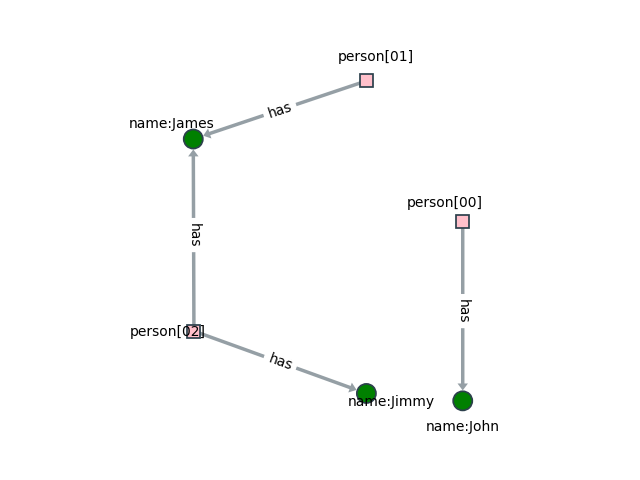

In [16]:
# The AnswerGraph plot method will plot onto the matplotlib plot. 
plt.figure() # For cleanliness, we'll tell matplotlib to create a new "figure" each time
plot_instance_1 = answer_graph.plot() # Limitations of netgraph require that you hold on to the returned value

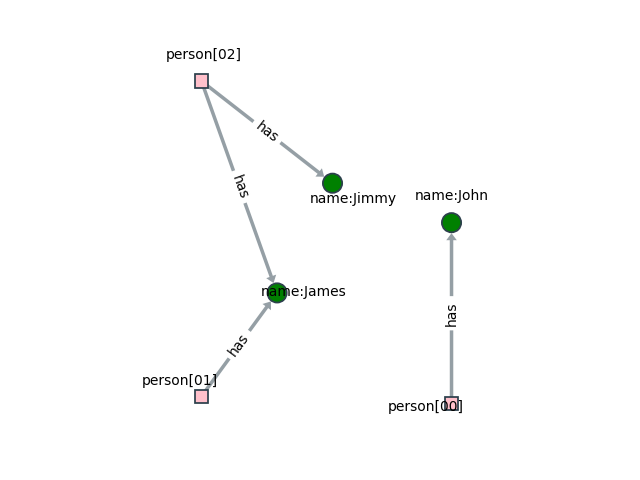

In [17]:
from typedb_jupyter.graph import visualise
plt.figure()
plot_instance_2 = visualise(_typeql_query_string, _typeql_result)

## Some more examples

In [18]:
%typedb transaction open typedb_jupyter_graphs read

Opened read transaction on database 'typedb_jupyter_graphs'  


In [19]:
%%typeql
match
$f isa friendship, links ($friend: $p1, $friend: $p2);
$p1 has name $n1;
$p2 has name $n2;

Query returned 6 rows.


f,friend,n1,n2,p1,p2
Relation(friendship: 0x1f00000000000000000000),RoleType(friendship:friend),"Attribute(name: ""John"")","Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000000),Entity(person: 0x1e00000000000000000001)
Relation(friendship: 0x1f00000000000000000000),RoleType(friendship:friend),"Attribute(name: ""James"")","Attribute(name: ""John"")",Entity(person: 0x1e00000000000000000001),Entity(person: 0x1e00000000000000000000)
Relation(friendship: 0x1f00000000000000000001),RoleType(friendship:friend),"Attribute(name: ""James"")","Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000001),Entity(person: 0x1e00000000000000000002)
Relation(friendship: 0x1f00000000000000000001),RoleType(friendship:friend),"Attribute(name: ""James"")","Attribute(name: ""Jimmy"")",Entity(person: 0x1e00000000000000000001),Entity(person: 0x1e00000000000000000002)
Relation(friendship: 0x1f00000000000000000001),RoleType(friendship:friend),"Attribute(name: ""James"")","Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000002),Entity(person: 0x1e00000000000000000001)
Relation(friendship: 0x1f00000000000000000001),RoleType(friendship:friend),"Attribute(name: ""Jimmy"")","Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000002),Entity(person: 0x1e00000000000000000001)


[|  $f: Relation(friendship: 0x1f00000000000000000000)  |  $friend: RoleType(friendship:friend)  |  $n1: Attribute(name: "John")  |  $n2: Attribute(name: "James")  |  $p1: Entity(person: 0x1e00000000000000000000)  |  $p2: Entity(person: 0x1e00000000000000000001)  |,
 |  $f: Relation(friendship: 0x1f00000000000000000000)  |  $friend: RoleType(friendship:friend)  |  $n1: Attribute(name: "James")  |  $n2: Attribute(name: "John")  |  $p1: Entity(person: 0x1e00000000000000000001)  |  $p2: Entity(person: 0x1e00000000000000000000)  |,
 |  $f: Relation(friendship: 0x1f00000000000000000001)  |  $friend: RoleType(friendship:friend)  |  $n1: Attribute(name: "James")  |  $n2: Attribute(name: "James")  |  $p1: Entity(person: 0x1e00000000000000000001)  |  $p2: Entity(person: 0x1e00000000000000000002)  |,
 |  $f: Relation(friendship: 0x1f00000000000000000001)  |  $friend: RoleType(friendship:friend)  |  $n1: Attribute(name: "James")  |  $n2: Attribute(name: "Jimmy")  |  $p1: Entity(person: 0x1e000000

In [20]:
%typedb transaction close

Transaction closed


/Users/krishnangovindraj/code/side/typedb-jupyter/src/.venv/lib/python3.11/site-packages/netgraph/_parser.py:23: UserWarning: Multi-graphs are not properly supported. Duplicate edges are plotted as a single edge; edge weights (if any) are summed.
  warnings.warn(msg)


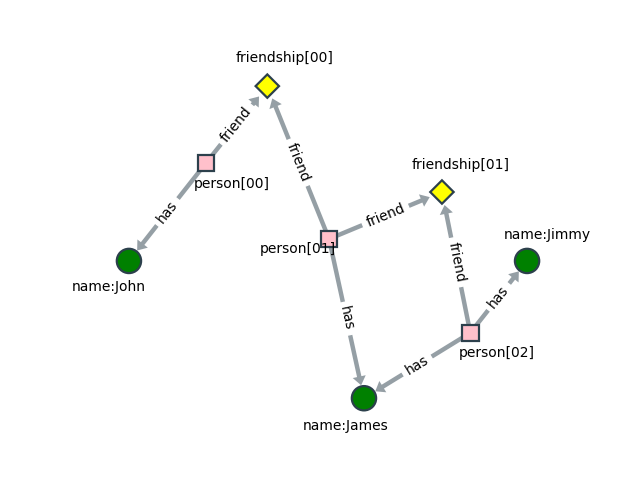

In [21]:
# As before, but we will use the convenience method this time
plt.figure()
plot_instance_3 = visualise(_typeql_query_string, _typeql_result)

### Custom visualisation
The IGraphVisualisationBuilder provides an interface for easy building. But first we get an easy query

In [22]:
%typedb transaction open typedb_jupyter_graphs read

Opened read transaction on database 'typedb_jupyter_graphs'  


In [23]:
%%typeql
match $p has name $n;


Query returned 4 rows.


n,p
"Attribute(name: ""John"")",Entity(person: 0x1e00000000000000000000)
"Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000001)
"Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000002)
"Attribute(name: ""Jimmy"")",Entity(person: 0x1e00000000000000000002)


[|  $n: Attribute(name: "John")  |  $p: Entity(person: 0x1e00000000000000000000)  |,
 |  $n: Attribute(name: "James")  |  $p: Entity(person: 0x1e00000000000000000001)  |,
 |  $n: Attribute(name: "James")  |  $p: Entity(person: 0x1e00000000000000000002)  |,
 |  $n: Attribute(name: "Jimmy")  |  $p: Entity(person: 0x1e00000000000000000002)  |]

In [24]:
%typedb transaction close

Transaction closed


In [25]:
# You can also customise this greatly through the 
from typedb_jupyter.graph.answer import IGraphVisualisationBuilder
from typedb_jupyter.graph.answer import EntityVertex, RelationVertex, AttributeVertex, HasEdge, LinksEdge
from typing import Any


class MyVisualisationBuilder(IGraphVisualisationBuilder):
    """
    This class will colour edges belonging to the same query
    """
    def __init__(self):
        self.edges = []
        self.edge_labels = dict()
        self.edge_colours = dict()
        self.current_colour = 0x000000000 # RGBA colour
        self.node_labels = dict()

    def notify_start_next_answer(self, index: int):
        # Change the colour for every new answer
        self.current_colour = (self.current_colour + 0x3377bb00) % 0x100000000
    
    def add_entity_vertex(self, answer_index: int, vertex: EntityVertex):
        self.node_labels[vertex] = "ENT[%s:%s]"%(vertex.type(), vertex.iid()[-4:])

    def add_relation_vertex(self, answer_index: int, vertex: RelationVertex):
        self.node_labels[vertex] = "REL[%s:%s]"%(vertex.type(), vertex.iid()[-4:])

    def add_attribute_vertex(self, answer_index: int, vertex: AttributeVertex):
        self.node_labels[vertex] = "ATT[%s:%s]"%(vertex.type(), vertex.iid())

    def add_has_edge(self, answer_index: int, edge: HasEdge):
        pair = (edge.lhs,edge.rhs)
        self.edges.append(pair)
        self.edge_labels[pair] = "has"
        self.edge_colours[pair] = "#%0.8x"%self.current_colour

    def add_links_edge(self, answer_index: int, edge: LinksEdge):
        pair = (edge.lhs,edge.rhs)
        self.edges.append(pair)
        self.edge_labels[pair] = edge.role()
        self.edge_colours[pair] = "#%0.8x"%self.current_colour


    def plot(self) -> Any:
        # https://netgraph.readthedocs.io/en/latest/index.html
        from netgraph import BaseGraph # We use InteractiveGraph to allow dragging
        return BaseGraph(
            self.edges,
            node_labels=self.node_labels,
            edge_color=self.edge_colours,
            node_layout='bipartite', # Try others: https://netgraph.readthedocs.io/en/latest/graph_classes.html#netgraph.InteractiveGraph
            node_label_offset=(0,-0.05)
        )


/Users/krishnangovindraj/code/side/typedb-jupyter/src/.venv/lib/python3.11/site-packages/netgraph/_node_layout.py:1214: UserWarning: The graph consistst of multiple components, and hence the partitioning into two subsets/layers is ambiguous!
Use the `subsets` argument to explicitly specify the desired partitioning.
  warnings.warn(msg)
/Users/krishnangovindraj/code/side/typedb-jupyter/src/.venv/lib/python3.11/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


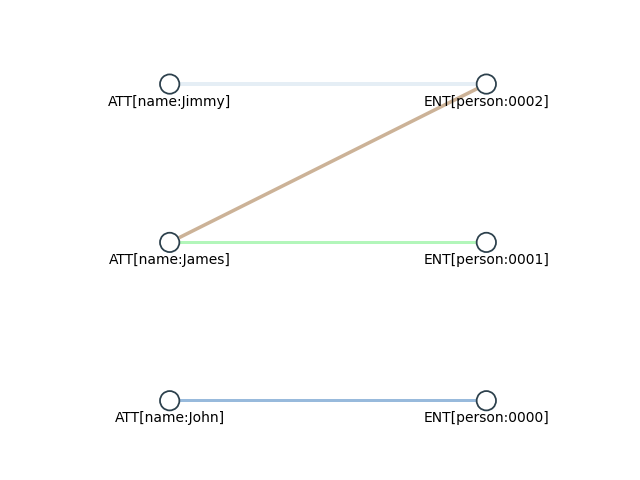

In [26]:
plt.figure()
parsed = TypeQLVisitor.parse_and_visit(_typeql_query_string)
query_graph = QueryGraph(parsed)
answer_graph = AnswerGraph.build(query_graph, _typeql_result)
plot_instance_4 = answer_graph.plot_with_visualiser(MyVisualisationBuilder())
# We can also call `visualise(_typeql_query_string, _typeql_result, MyVisualisationBuilder())`